# Contradictory, My Dear Watson

Link: https://www.kaggle.com/competitions/contradictory-my-dear-watson

Challenge description:

If you have two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

Your task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages! You can find more details on the dataset by reviewing the Data page.

Today, the most common approaches to NLI problems include using embeddings and transformers like BERT. In this competition, we’re providing a starter notebook to try your hand at this problem using the power of Tensor Processing Units (TPUs). TPUs are powerful hardware accelerators specialized in deep learning tasks, including Natural Language Processing. Kaggle provides all users TPU Quota at no cost, which you can use to explore this competition. Check out our TPU documentation and Kaggle’s YouTube playlist for more information and resources.


!pip install transformers -qU
!pip install datasets -qU
!pip install pip install pytorch-lightning -qU

In [1]:
import re
import time
from typing import List, Optional, Tuple
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import torch
from torch.nn import ConstantPad1d
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping

from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    AdamW
)

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [2]:
df = pd.read_csv("data/train.csv")

labels_mapping = {0: "entailment", 1: "neutral", 2: "contradiction"}
ids_to_language = {i: language for i, language in enumerate(df["language"].unique())}
language2ids = {language: i for i, language in ids_to_language.items()}

df['premise']  = df['premise'].apply(lambda x: x.lower())
df['hypothesis']  = df['hypothesis'].apply(lambda x: x.lower())
df['inputs'] = "[CLS] " + df['premise'] + " [SEP] " + df['hypothesis'] + " [SEP]"
df['language_id'] = df["language"].map(language2ids)
df['label_name'] = df["label"].map(labels_mapping)
df.drop(["id", "lang_abv"], axis=1, inplace=True)
df.head()

,premise,hypothesis,language,label,inputs,language_id,label_name
0,and these comments were considered in formulating the interim rules.,the rules developed in the interim were put together with these comments in mind.,English,0,[CLS] and these comments were considered in formulating the interim rules. [SEP] the rules developed in the interim were put together with these comments in mind. [SEP],0,entailment
1,"these are issues that we wrestle with in practice groups of law firms, she said.",practice groups are not permitted to work on these issues.,English,2,"[CLS] these are issues that we wrestle with in practice groups of law firms, she said. [SEP] practice groups are not permitted to work on these issues. [SEP]",0,contradiction
2,des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.,j'essayais d'accomplir quelque chose.,French,0,[CLS] des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire. [SEP] j'essayais d'accomplir quelque chose. [SEP],1,entailment
3,you know they can't really defend themselves like somebody grown uh say my age you know yeah,they can't defend themselves because of their age.,English,0,[CLS] you know they can't really defend themselves like somebody grown uh say my age you know yeah [SEP] they can't defend themselves because of their age. [SEP],0,entailment
4,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,Thai,1,[CLS] ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้ [SEP] เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร [SEP],2,neutral


# Data Overview

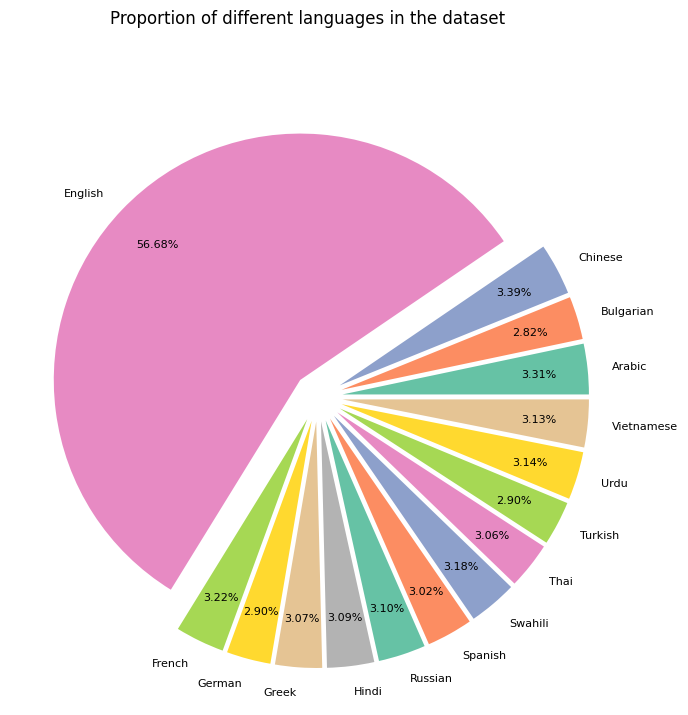

In [3]:
df_stats = df.groupby("language").agg(count=("premise", 'count')).reset_index()
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle("Proportion of different languages in the dataset")
ax.pie(df_stats["count"], labels=df_stats["language"], 
       autopct='%1.2f%%', 
       explode= [0.1]*len(df_stats),
       textprops={'fontsize': 8},
       labeldistance=1.1,
       pctdistance=0.8,
       colors=sns.color_palette('Set2'))
fig.show()

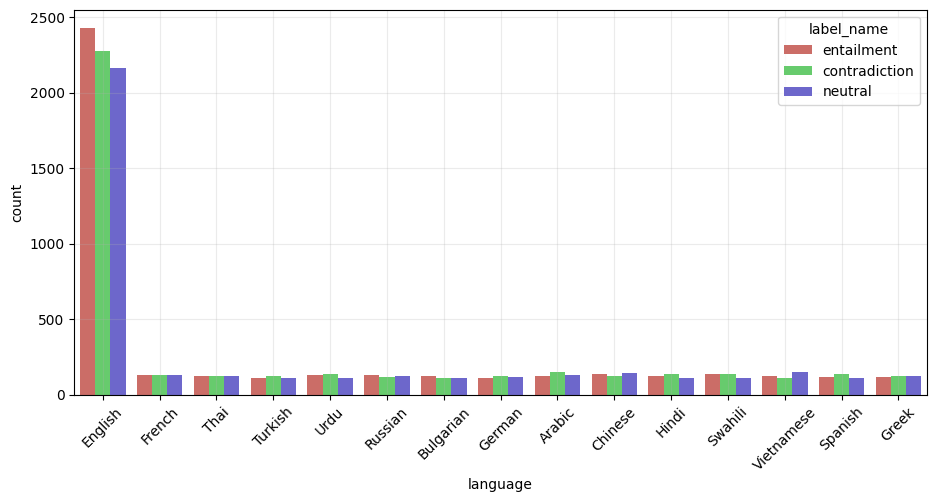

In [4]:
fig, ax = plt.subplots(figsize=(11,5))
sns.countplot(data=df, x="language", hue="label_name", palette="hls", ax=ax)
ax.grid(alpha=0.25)
ax.tick_params(axis='x', rotation=45)

# Tokenizer & Model


In [5]:
model_name_or_path = "bert-base-uncased"#'symanto/xlm-roberta-base-snli-mnli-anli-xnli'

model= AutoModelForSequenceClassification.from_pretrained(model_name_or_path,
                                                          num_labels = 3,
                                                          ignore_mismatched_sizes=True,
                                                          output_attentions = False,
                                                          output_hidden_states = False)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, do_lower_case=True)
tokenizer.special_tokens_map

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

# Dataset

In [6]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs = df["inputs"].values
        self.labels = torch.tensor(df["label"].values).to(torch.int64)
        self.language = torch.tensor(df["language_id"].values).to(torch.int64)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs[idx],
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        return encoded_dict['input_ids'][0], encoded_dict['attention_mask'][0], self.labels[idx], self.language[idx]

    def __len__(self):
        return len(self.labels)

In [7]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))


9,696 training samples
2,424 validation samples


# Dataloaders

In [8]:
def padding_function(x, max_len):
    return ConstantPad1d((0, max_len - len(x)), 0)(x)

def collate_fn(batch):
    max_len = max([len(sample[0]) for sample in batch])
    ids = torch.stack([padding_function(sample[0], max_len) for sample in batch])
    attention_masks = torch.stack([padding_function(sample[1], max_len) for sample in batch])
    labels = torch.tensor([sample[2] for sample in batch])
    language = torch.tensor([sample[3] for sample in batch])

    return ids.to(device), attention_masks.to(device), labels.to(device), language.to(device)


In [9]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

# Train model

In [10]:
avg_train_accuracy = []
avg_train_loss = []
avg_val_loss = []
avg_val_accuracy = []

epochs = 3
learning_rate = 1e-5
adam_epsilon = 1e-7
weight_decay = 0.005

optimizer = AdamW(model.parameters(), lr=learning_rate,  eps=adam_epsilon)

In [11]:
for epoch_i in range(0, epochs):

    running_train_loss = 0
    running_train_accuracy = 0
    running_val_loss = 0
    running_val_accuracy = 0

    model.train()

    loop = tqdm(train_dataloader)

    for batch in loop:

        optimizer.zero_grad()

        print(batch[0].shape)
        output = model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])

        label_ids = batch[3].to('cpu').numpy()
        predictions = torch.argmax(output.logits.detach().cpu(), 1).numpy()
        running_train_accuracy += (label_ids==predictions).sum()

        loss = output.loss
        running_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        loop.set_description(f"Training. Epoch [{epoch_i}/{epochs}]")
        loop.set_postfix(loss=loss.item(), acc=(label_ids==predictions).sum()/len(predictions))

    avg_train_accuracy.append(running_train_accuracy / train_size)
    avg_train_loss.append(running_train_loss / train_size)

    model.eval()

    with torch.no_grad():
        loop = tqdm(validation_dataloader)
        for batch in loop:

            output = model(input_ids=batch[0],
                          token_type_ids=batch[1],
                          attention_mask=batch[2],
                          labels=batch[3])

            label_ids = batch[3].to('cpu').numpy()
            predictions = torch.argmax(output.logits.detach().cpu(), 1).numpy()
            running_val_accuracy += (label_ids==predictions).sum()

            loss = output.loss
            running_val_loss += loss.item()

            loop.set_description(f"Validation. Epoch [{epoch_i}/{epochs}]")
            loop.set_postfix(loss=loss.item(), acc=(label_ids==predictions).sum()/len(predictions))

    avg_val_accuracy.append(running_val_accuracy / validation_size)
    avg_val_loss.append(running_val_loss / validation_size)

  0%|          | 0/606 [00:00<?, ?it/s]

torch.Size([16, 212])


ValueError: Wrong shape for input_ids (shape torch.Size([16, 212])) or attention_mask (shape torch.Size([16]))

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12, 7), sharex=True, sharey=True)

axs[0][0].plot(avg_train_loss)
axs[0][0].set_title("Average training loss")

axs[0][1].plot(avg_val_loss)
axs[0][1].set_title("Average validation loss")

axs[1][0].plot(avg_train_accuracy)
axs[1][0].set_title("Average train accuracy")

axs[1][1].plot(avg_val_accuracy)
axs[1][1].set_title("Average validation accuracy")

axs[1][0].set_xlabel("Epoch")
axs[1][1].set_xlabel("Epoch")
axs[1][0].set_ylabel("Accuracy")
axs[0][0].set_ylabel("Loss")

for row in axs:
    for ax in row:
        ax.grid(c='gray', alpha=0.5)

# Evaluate

In [ ]:
def evaluate(model, dataloader):

    true_labels = []
    predicted_labels = []
    language = []

    for i, batch in enumerate(dataloader):

        output = model(input_ids=batch[0],
                          attention_mask=batch[1],
                          labels=batch[2])
        true_labels.append(batch[2].to('cpu').numpy())
        language.append(batch[3].to('cpu').numpy())
        predicted_labels.append(torch.argmax(output.logits.detach().cpu(), 1).numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.concatenate(predicted_labels, axis=0)
    language = np.concatenate(language, axis=0)

    res_df = pd.DataFrame({"TrueLabel": true_labels, "PredictedLabel": predicted_labels, "LanguageId": language})
    res_df["Language"] = res_df["LanguageId"].map(ids_to_language)
    res_df["CorrectPrediction"] = (res_df["TrueLabel"] == res_df["PredictedLabel"])
    res_df = res_df.groupby("Language")["CorrectPrediction"].agg(CorrectPredictions="sum", AllPredictions="count")
    res_df["Accuracy"] = round(res_df['CorrectPredictions']/res_df["AllPredictions"], 2)
    res_dict = res_df["Accuracy"].to_dict()
    res_dict["Average"] = round(sum(true_labels==predicted_labels)/len(true_labels), 2)
    res_dict["NumberOfSamples"] = len(true_labels)

    print(res_dict)
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2], normalize='true')
    ax= plt.subplot()
    sns.heatmap(np.round(cm, 2), annot=True, fmt='g', ax=ax, cmap='cool')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(["entailment", "neutral", "contradiction"])
    ax.yaxis.set_ticklabels(["entailment", "neutral", "contradiction"])
    plt.show()

    return res_dict

In [ ]:
evaluate(model, train_dataloader)
evaluate(model, validation_dataloader)

# Save pretrained model

In [ ]:
model.save_pretrained("classification_model")
tokenizer.save_pretrained("tokenizer")

In [ ]:
model= AutoModelForSequenceClassification.from_pretrained("classification_model",
                                                                num_labels = 3,
                                                                ignore_mismatched_sizes=True,
                                                                output_attentions = False,
                                                                output_hidden_states = False)


# Predict

In [ ]:
test_df = pd.read_csv("data/test.csv")

test_df['premise']  = test_df['premise'].apply(lambda x: x.lower())
test_df['hypothesis']  = test_df['hypothesis'].apply(lambda x: x.lower())
test_df['inputs'] = "[CLS] " + test_df['premise'] + " [SEP] " + test_df['hypothesis'] + " [SEP]"
test_df.drop(["premise", "hypothesis", "lang_abv", "language"], axis=1, inplace=True)

test_df.head()

In [ ]:
def predict(inputs):

    encoded_dict = tokenizer(inputs,
                            add_special_tokens = True,
                            return_attention_mask = True,
                            return_tensors = 'pt',
                   )

    output = model(input_ids=encoded_dict["input_ids"],
                          attention_mask=encoded_dict["attention_mask"])
    label = torch.argmax(output.logits.detach().cpu(), 1)
    return int(label)

    

In [ ]:
test_df["prediction"] = test_df["inputs"].apply(lambda x: predict(x))

In [ ]:
test_df[["id", "prediction"]].to_csv("data/submission.csv", index=False)